# Geofísica Matemática y Computacional.

## Examen

### 23 de noviembre de 2021

Antes de entregar este *notebook*, asegúrese de que la ejecución se realiza como se espera.
1. Reinicie el kernel.
    - Para ello seleccione en el menú principal: Kernel$\rightarrow$Restart.
2. Llene todos las celdas que indican:
    - `YOUR CODE HERE` o
    - "YOUR ANSWER HERE"
3. Ponga su nombre en la celda siguiente (y el de sus colaboradores si es el caso).
4. Una vez terminado el ejercicio haga clic en el botón Validate y asegúrese de que no hay ningún error en la ejecución.

In [1]:
NAME = "Jesus Sanchez Gonzalez"
COLLABORATORS = ""

---

# Convección-difusión de calor NO estacionaria
Considere el siguiente problema:

$$
\begin{eqnarray*}
\frac{\partial T}{\partial t} +
u \frac{\partial T}{\partial x} -
\kappa \frac{\partial^2 T}{\partial x^2} & = & 0 \\
T(0, t) & = & 1 \qquad \text{para} \qquad 0 < t < T_{max} \\
T(L, t) & = & 0 \qquad \text{para} \qquad 0 < t < T_{max} \\
T(x, 0) & = & 0 \qquad \text{para} \qquad 0 < x \leq L
\end{eqnarray*}
$$

<img src="conv03.png" width="300" align="middle">

La solución analítica es la siguiente:

$$
\displaystyle
T(x,t) = 0.5  \left[\text{erfc}\left(\frac{x - ut}{2 \sqrt{\kappa t}}\right) +
\exp\left(\frac{u x}{\kappa}\right)
\text{erfc}\left(\frac{x + ut}{2 \sqrt{\kappa t}}\right) \right]
$$

Implementar la solución numérica con diferencias finitas en Python.

Utilice los siguientes datos:

- $L = 2.5$ [m],  
- $T_{max} = 1$ [s]
- $h_t = 0.002$ [s]

La $u$ y la $\kappa$ se definen más adelante.

- $\kappa = 0.001$ [kg/m s], 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
params = {'figure.figsize' : (10,7),
#          'text.usetex'    : True,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'axes.labelsize' : 24,
          'axes.titlesize' : 24,
          'legend.fontsize': 12,
          'lines.linewidth': 3,
          'lines.markersize': 10,
          'grid.color'     : 'darkgray',
          'grid.linewidth' : 0.5,
          'grid.linestyle' : '--',
          'font.family': 'DejaVu Serif',
         }
plt.rcParams.update(params)

In [3]:
def mesh(L,N):
    x = np.linspace(0,L,N+2)
    return (L / (N+1), x)

## Cálculo de la matriz
En la siguiente función deberá implementar el cálculo de la matriz del sistema de tal manera que mediante el parámetro `scheme` se pueda elegir entre el esquema de **Diferencias Centradas** y el **Upwind**. Tendrá entonces que escribir un código similar al siguiente:

```python
    if scheme == 'C': # Caso: Diferencias Centradas
        b = ...
        c = ...
    elif scheme == 'U': # Caso: Upwind
        ...
```

In [4]:
def Laplaciano1D(par, scheme):#N, h, ht, Gamma, rho, v):
    u     = par['u'] 
    kappa = par['kappa']
    N     = par['N'] 
    h     = par['h']
    ht    = par['ht']

    # YOUR CODE HERE
    # kappa = alpha a partir del problema estacionario
    ce = 0 # Velocidad positiva
    cw = u/h #Velocidad positiva
    if scheme == 'C':
        b = -((ht*u) / (2*h)) + ((ht*kappa) / (h*h))
        c = ((ht*u) / (2*h)) + ((ht*kappa) / (h*h))
    elif scheme == 'U':
        b = (ht*ce) + ((ht*kappa) / (h*h))
        c = (ht*cw) + ((ht*kappa) / (h*h))
    
    a = b + c 
    A = np.zeros((N,N))
    A[0,0] = a + 1
    A[0,1] = -b
    for i in range(1,N-1):
        A[i,i] = a + 1
        A[i,i+1] = -b
        A[i,i-1] = -c
    A[N-1,N-2] = -c
    A[N-1,N-1] = a + 1
    
    return A

## Cálculo del RHS
De igual manera que en el caso de la matriz, deberá implementar en la siguiente función los casos para calcular el RHS del sistema usando **Diferencias Finitas** o **Upwind** dependiendo del valor de `scheme`.

In [5]:
def RHS(par, T, scheme):
    u     = par['u'] 
    kappa = par['kappa']
    N     = par['N'] 
    h     = par['h']
    ht    = par['ht']
    T0    = par['BC'][0]
    TL    = par['BC'][1]

    f = np.copy(T[1:N+1])

    # YOUR CODE HERE
    ce = 0 # Velocidad positiva
    cw = u/h #Velocidad positiva
    if scheme == 'C':
        b = -((ht*u) / (2*h)) + ((ht*kappa) / (h*h))
        c = ((ht*u) / (2*h)) + ((ht*kappa) / (h*h))
    elif scheme == 'U':
        b = (ht*ce) + ((ht*kappa) / (h*h))
        c = (ht*cw) + ((ht*kappa) / (h*h))
    
    S = 0 # A partir del problema estacionario
    cp = 1
    rho = 1
    
    f[0:-1] += S/(cp*rho)
    f[0]   += ht * c * T0  
    f[N-1] += ht * b * TL
    
    return f

## Solución analítica.

Observe que la solución analítica contiene la función especial $erfc(x)$ que es la <a href='https://mathworld.wolfram.com/Erfc.html'>función error complementaria</a>. Esta función la puede usar a través de la biblioteca `special` de `scipy` (incluya `from scipy import special`) :

```python
    special.erfc( ... )
```


In [6]:
from scipy import special

def analyticSol(par, i, NP = 100):
    L     = par['L']
    u     = par['u']
    kappa = par['kappa']
    t     = par['ht'] * i

    # YOUR CODE HERE
    xa = np.linspace(0, L, NP) # Coordenadas X
    Ta = 0.5 * (special.erfc((xa-(u*t))/(2*np.sqrt(kappa*t))) + (np.exp(u*xa/kappa)*special.erfc((xa+(u*t))/(2*np.sqrt(kappa*t)))))
    
    return xa, Ta

## Cálculo de la solución numérica

Debido a que usamos el método implícito, en el siguiente código deberá incluir la llamada a las funciones para calcular la matriz, el RHS y la solución del sistema.


In [7]:
def numSol(par, T, scheme):
    L     = par['L']
    N     = par['N']
    ht    = par['ht']
    Nt    = par['Nt']
    freq  = par['freq']

    error = []
    x = np.linspace(0,L,N+2)
    Told = T.copy()
    for i in range(1, Nt+1):        
        # YOUR CODE HERE    
        A = Laplaciano1D(par, scheme)
        f = RHS(par, Told, scheme)
        T[1:N+1]= np.linalg.solve(A,f)
        Told = T.copy()
    
        if (i % freq == 0):
            xa, Ta = analyticSol(par, i, N+2)
            E = np.linalg.norm(Ta - T)
            error.append(E)
            etiqueta = 'Step = {:2.1f}, $||E||_2$ = {:5.6f}'.format(i*ht, E)
            plt.plot(x, T, '-', lw = 1.5, label=etiqueta)
            plt.plot(xa, Ta, '--', lw = 1.0, color='gray')
    
    return error

In [8]:
def casos(u, kappa, N, scheme):
    par = {}
    par['L']     = 2.5 # m
    par['kappa'] = kappa # kg / m.s
    par['u']     = u # m/s
    par['BC']    = (1.0, 0.0)
    par['N']     = N # Número de incógnitas
    par['Tmax']  = 1.0
    par['ht']    = 0.001
    par['Nt']    = int(par['Tmax'] / par['ht'])
    par['freq']  = 100
    h, x = mesh(par['L'], par['N'])
    par['h'] = h

    N  = par['N']
    T0 = par['BC'][0]
    TL = par['BC'][1]

    T = np.zeros(N+2)
    T[0] = T0
    T[-1] = TL
    xa, Ta = analyticSol(par, par['Nt'])
    
    plt.figure(figsize=(10,5))

    error = numSol(par, T, scheme)
    plt.plot(xa,Ta, '--', lw=1.0, color='gray', label='Analítica')
    plt.xlabel('x [m]')
    plt.ylabel('T [$^o$C]')
    plt.grid()
    plt.legend(loc='upper right')
        
    plt.show()

### Caso 1.

Calcule la solución usando los siguientes datos:

- $u = 1.0$
- $\alpha = 0.01$
- $N = 100$
- Esquema: Diferencias Centradas

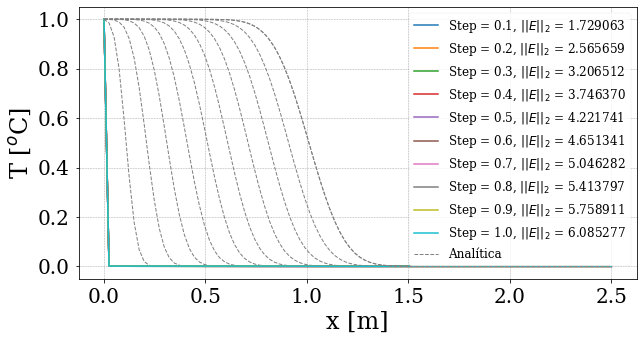

In [9]:
# YOUR CODE HERE
casos(1.0, 0.01, 100,'C')

### Caso 2.

Calcule la solución usando los siguientes datos:

- $u = 1.0$
- $\alpha = 0.01$
- $N = 100$
- Esquema: Upwind

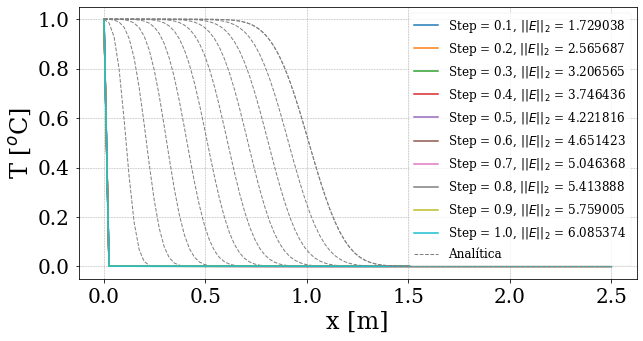

In [10]:
# YOUR CODE HERE
casos(1.0, 0.01, 100,'U')

### Pregunta 1: 
    1.1 ¿Cual de los casos 1 y 2 proporciona una mejor solución? <br>
    1.2 ¿Por qué sucede esto?

El segundo caso
Porque se estabiliza con el uso de una norma O(h) para el termino temporal

### Caso 3.

Calcule la solución usando los siguientes datos:

- $u = 1.0$
- $\alpha = 0.001$
- $N = 100$
- Esquema: Diferencias Centradas

/tmp/ipykernel_51307/3820831108.py:11: RuntimeWarning: overflow encountered in exp
  Ta = 0.5 * (special.erfc((xa-(u*t))/(2*np.sqrt(kappa*t))) + (np.exp(u*xa/kappa)*special.erfc((xa+(u*t))/(2*np.sqrt(kappa*t)))))
/tmp/ipykernel_51307/3820831108.py:11: RuntimeWarning: invalid value encountered in multiply
  Ta = 0.5 * (special.erfc((xa-(u*t))/(2*np.sqrt(kappa*t))) + (np.exp(u*xa/kappa)*special.erfc((xa+(u*t))/(2*np.sqrt(kappa*t)))))
/tmp/ipykernel_51307/3820831108.py:11: RuntimeWarning: overflow encountered in exp
  Ta = 0.5 * (special.erfc((xa-(u*t))/(2*np.sqrt(kappa*t))) + (np.exp(u*xa/kappa)*special.erfc((xa+(u*t))/(2*np.sqrt(kappa*t)))))
/tmp/ipykernel_51307/3820831108.py:11: RuntimeWarning: invalid value encountered in multiply
  Ta = 0.5 * (special.erfc((xa-(u*t))/(2*np.sqrt(kappa*t))) + (np.exp(u*xa/kappa)*special.erfc((xa+(u*t))/(2*np.sqrt(kappa*t)))))
/tmp/ipykernel_51307/3820831108.py:11: RuntimeWarning: overflow encountered in exp
  Ta = 0.5 * (special.erfc((xa-(u*t))/(2*np.s

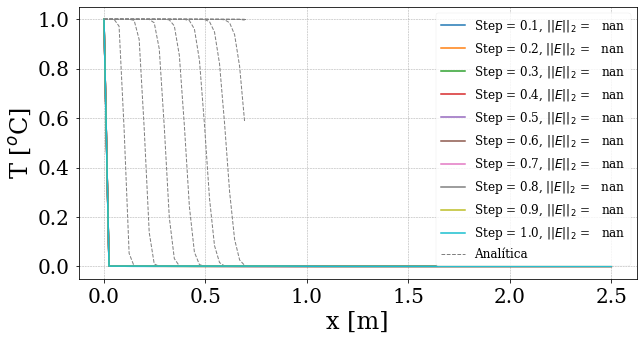

In [11]:
# YOUR CODE HERE
casos(1.0, 0.001, 100,'C')

### Pregunta 2: 
¿Cómo podría mejorar la solución del caso 3?

Cambiando el paso de tiempo

### Caso 4.

Calcule la solución usando los siguientes datos:

- $u = 1.0$
- $\alpha = 0.001$
- $N = 100$
- Esquema: Upwind

/tmp/ipykernel_51307/3820831108.py:11: RuntimeWarning: overflow encountered in exp
  Ta = 0.5 * (special.erfc((xa-(u*t))/(2*np.sqrt(kappa*t))) + (np.exp(u*xa/kappa)*special.erfc((xa+(u*t))/(2*np.sqrt(kappa*t)))))
/tmp/ipykernel_51307/3820831108.py:11: RuntimeWarning: invalid value encountered in multiply
  Ta = 0.5 * (special.erfc((xa-(u*t))/(2*np.sqrt(kappa*t))) + (np.exp(u*xa/kappa)*special.erfc((xa+(u*t))/(2*np.sqrt(kappa*t)))))
/tmp/ipykernel_51307/3820831108.py:11: RuntimeWarning: overflow encountered in exp
  Ta = 0.5 * (special.erfc((xa-(u*t))/(2*np.sqrt(kappa*t))) + (np.exp(u*xa/kappa)*special.erfc((xa+(u*t))/(2*np.sqrt(kappa*t)))))
/tmp/ipykernel_51307/3820831108.py:11: RuntimeWarning: invalid value encountered in multiply
  Ta = 0.5 * (special.erfc((xa-(u*t))/(2*np.sqrt(kappa*t))) + (np.exp(u*xa/kappa)*special.erfc((xa+(u*t))/(2*np.sqrt(kappa*t)))))
/tmp/ipykernel_51307/3820831108.py:11: RuntimeWarning: overflow encountered in exp
  Ta = 0.5 * (special.erfc((xa-(u*t))/(2*np.s

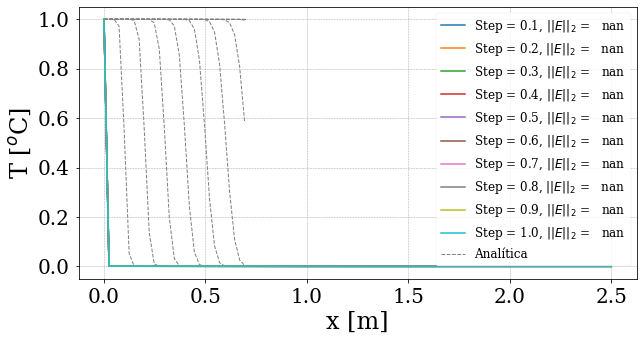

In [12]:
# YOUR CODE HERE
casos(1.0, 0.001, 100,'U')

### Pregunta 3: 
¿Cómo podría mejorar la solución del caso 4?

Estableciendo un valor de tolerancia